In [ ]:
# hide
# default_exp cli
from nbdev.showdoc import show_doc
from nbdev import *

# CLI

> The command line interface for the HECSS sampler

The hecss sampler can be also used from the command line using `hecss` command:
```bash
~$ hecss --help
Usage: hecss [OPTIONS] FNAME

  Run HECSS sampler on the structure in the directory. 
  fname - Supercell structure file.  
          The containing directory must be readable by Vasp(restart).

Options:
  -W, --workdir PATH      Work directory
  -l, --label TEXT        Label for the calculations.
  -T, --temp FLOAT        Target temperature in Kelvin.
  -w, --width FLOAT       Initial scale of the prior distribution
  -C, --calc TEXT         ASE calculator to be used for the job. 
                          Supported calculators: VASP (default)
  -n, --nodfset           Do not write DFSET file for ALAMODE
  -N, --nsamples INTEGER  Number of samples to be generated
  -c, --command TEXT      Command to run calculator
  -V, --version           Print version and exit
  --help                  Show this message and exit.
```

To use it you need to prepare:

1. `run-calc` script which should start the VASP calculation. You need to put this script in the root of your project tree. The example of such a script is included in the source as `run-calc.example`. :

```bash
#!/bin/bash

# This script should run vasp in current directory 
# and wait for the run to finish.
# 
# A generic line using SLURM would look like this:
#
# sbatch [job_params] -W vasp_running_script
#
# The "-W" param makes the sbatch command wait for the job to finish.


JN=`pwd`
JN=`basename ${JN}`

# Partition of the cluster
PART=small

# Number of nodes
N=1

# Number of MPI tasks
ntask=64

# Name the job after directory if no label is passed as first argument
if [ "${1}." != "." ]; then
  JN=${1}
fi

sbatch -W -J ${JN} -p $PART -N $N -n $ntask run-vasp-script
```

2. A directory with fully converged and optimized supercell structure which can be read in by the ASE `Vasp(restart=...)` command

3. A directory for the generated samples.

The directory tree may look like this:

```
my_project ----- sc
             |
             +-- T_100
             |
             +-- T_200
             |
             +-- ...
             |
             +-- run-calc
```

You execute the sampler from the `my_project` directory (remember to activate your virtual environment first). Generation of N=30 samples at T=100K:

```bash
~$ cd my_project
~$ hecss -W T_100 --T 100 --N 30 -c ./run-calc sc/CONTCAR
```

The above command will put the generated samples inside the `T_100` directory, together with the DFSET file with displacement-force data extracted from the calculation. The calculation may take a long time. Thus it is advisable to execute the hecss command inside `screen` (or some similar terminal multiplexer) to prevent the break of the calculation in case of session disconnection. The `hecss` command shows a progress to guide you through the calculation (ETA, time/it, data about last sample etc.). The example run is included at the bottom of this document.

In [ ]:
# hide
# export
import click
from pathlib import Path
import os
import ase
from ase.calculators.vasp import Vasp
from ase import units as un
from hecss.core import *
import hecss

In [ ]:
# export
def dfset_writer(s, sl, workdir=''):
    '''
    Just write samples to the DFSET.dat file in the workdir directory.
    '''
    wd = Path(workdir)
    write_dfset(f'{wd.joinpath("DFSET.dat")}', s)
    # Important! Return False to keep iteration going
    return False

In [ ]:
# export
@click.command()
@click.argument('fname', type=click.Path())            
@click.option('-W', '--workdir', default="WORK", type=click.Path(exists=True), help="Work directory")
@click.option('-l', '--label', default="hecss", help="Label for the calculations.")
@click.option('-T', '--temp', default=300, type=float, help="Target temperature in Kelvin.")
@click.option('-w', '--width', default=1.0, type=float, help="Initial scale of the prior distribution")
@click.option('-C', '--calc', default="VASP", type=str, 
              help="ASE calculator to be used for the job. "
                      "Supported calculators: VASP (default)")
@click.option('-n', '--nodfset', is_flag=True, help='Do not write DFSET file for ALAMODE')
@click.option('-N', '--nsamples', default=10, type=int, help="Number of samples to be generated")
@click.option('-c', '--command', default='./run-calc', help="Command to run calculator")
@click.version_option(hecss.__version__, '-V', '--version',
                      message="HECSS, version %(version)s\n"
                          'High Efficiency Configuration Space Sampler\n'
                          '(C) 2021 by Paweł T. Jochym\n'
                          '    License: GPL v3 or later')
@click.help_option('-h', '--help')
def hecss_sampler(fname, workdir, label, temp, width, calc, nodfset, nsamples, command):
    '''
    Run HECSS sampler on the structure in the provided file (FNAME).
    
    \b
    FNAME - Supercell structure file. The containing 
            directory must be readable by Vasp(restart).
            Usually this is a CONTCAR file for a supercell.
    '''
    
    print(f'HECSS ({hecss.__version__})\n'
          f'Supercell:      {fname}\n'
          f'Temperature:    {temp}K\n'
          f'Work directory: {workdir}\n'
          f'Calculator:     {calc}')
    
    src_path = Path(fname)
    
    if calc=="VASP":
        calculator = Vasp(label=label, directory=src_path.parent, restart=True)
        cryst = ase.Atoms(calculator.atoms)
        cryst.set_calculator(calculator)
        calculator.set(directory=workdir)
        command = Path(command)
        calculator.set(command=f'{command.absolute()} {label}')
    else:
        print(f'The {calc} calculator is not supported.')
        return
    
    if nodfset :
        sentinel = None
    else :
        sentinel = dfset_writer
    sampler = HECSS(cryst, calculator, temp, directory=workdir, width=width)
    samples = sampler.generate(nsamples, sentinel=sentinel, workdir=workdir)
    return

In [ ]:
from click.testing import CliRunner
print(CliRunner().invoke(hecss_sampler, '-V').output)

HECSS, version 0.3.17
High Efficiency Configuration Space Sampler
(C) 2021 by Paweł T. Jochym
    License: GPL v3 or later



In [ ]:
print(CliRunner().invoke(hecss_sampler, '--help').output)

Usage: hecss-sampler [OPTIONS] FNAME

  Run HECSS sampler on the structure in the provided file (FNAME).

  FNAME - Supercell structure file. The containing 
          directory must be readable by Vasp(restart).
          Usually this is a CONTCAR file for a supercell.

Options:
  -W, --workdir PATH      Work directory
  -l, --label TEXT        Label for the calculations.
  -T, --temp FLOAT        Target temperature in Kelvin.
  -w, --width FLOAT       Initial scale of the prior distribution
  -C, --calc TEXT         ASE calculator to be used for the job. Supported
                          calculators: VASP (default)
  -n, --nodfset           Do not write DFSET file for ALAMODE
  -N, --nsamples INTEGER  Number of samples to be generated
  -c, --command TEXT      Command to run calculator
  -V, --version           Show the version and exit.
  -h, --help              Show this message and exit.



In [ ]:
# vasp
# slow
from click.testing import CliRunner

# reset output file
open('TMP/DFSET.dat', 'wt').close()

print(CliRunner().invoke(hecss_sampler, 
                         "-W TMP -T 300 -N 100 -w 1.1"
                         " example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR").output)

0it [00:00, ?it/s]

HECSS (0.3.17)
Supercell:      example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR
Temperature:    300.0K
Work directory: TMP
Calculator:     VASP



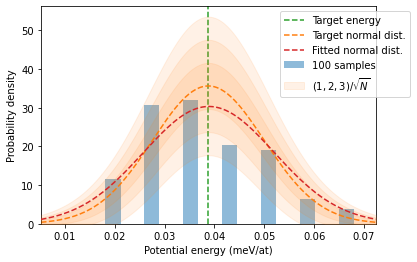

In [ ]:
# vasp
# slow
from hecss.monitor import plot_stats, load_dfset

plot_stats(load_dfset('TMP','DFSET.dat'), 300)